## Noisy Lotka Volterra System - Simulation & Identification

## Model Identification of Diffusion Processes via Moment Closure Approximations

In this notebook, we look at the problem of identifying model parameters of a diffusion process given timeseries data on key moments of the process. Specifically, we will use moment closure approximations to improve efficiency of the identification process by reducing the model evaluation time. For this example, we will consider a noisy variation of the Lotka-Volterra model for the interaction between a predator and prey species:

$$\begin{bmatrix} dx \\ dy \end{bmatrix}= \begin{bmatrix} \gamma_1 x(t) - \gamma_2  x(t)  y(t) \\ \gamma_4 x(t)  y(t) - \gamma_3 y(t) - \frac{1}{2} y(t) \end{bmatrix} \, dt + \begin{bmatrix}  \gamma_5 x \\ 0 \end{bmatrix} \, dW_t  $$

Throughout, we will rely on ModelingToolkit.jl to build the models which will then be solved using the existing infrastructure in DifferentialEquations.jl and its meta packages for simulating dynamical systems and stochastic processes.

In [1]:
using MomentClosure, ModelingToolkit, DifferentialEquations, DiffEqParamEstim, Optim, LinearAlgebra, DifferentialEquations.EnsembleAnalysis, Plots

┌ Info: Precompiling MomentClosure [01a1b25a-ecf0-48c5-ae58-55bfd5393600]
└ @ Base loading.jl:1317


In [2]:
@variables t, x(t), y(t)
@parameters γ[1:5]
drift_eqs = [Differential(t)(x) ~ γ[1] * x - γ[2] * x * y ;
             Differential(t)(y) ~ γ[4] * x * y - γ[3] * y - y*0.5]
diff_eqs = [γ[5]*x; 0]
LV = SDESystem(drift_eqs, diff_eqs, t, [x,y], γ)

Next, we will generate some data used for the estimation process. In this case, we will collect timeseries data on means and variances of both states of the process.

In [ ]:
N_samples = 1000
Tf = 10
t_data = 0:0.2:Tf
p_true = [γ[1] => 1, γ[2] => 2, γ[3] => 1, γ[4] => 2, γ[5] => 0.1]
u0 = [1.0, 0.25]
LV_data = solve(EnsembleProblem(SDEProblem(LV, u0, (0.0, Tf), p_true)), saveat = t_data, trajectories = N_samples)
means, vars = timeseries_steps_meanvar(LV_data)

(t: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0]
u: [[1.0, 0.25], [1.1002282766112859, 0.2820327429080564], [1.1911720894666393, 0.33072524123537567], [1.2580119671395282, 0.40082064126409395], [1.2827243166320181, 0.49529690187280373], [1.2516263259734108, 0.6117752166946948], [1.1670674441606277, 0.7382236210239407], [1.0352519268123102, 0.8513337780329507], [0.8857487263544734, 0.9254360146554965], [0.7445302626477134, 0.9478621741597564]  …  [0.4074927785373967, 0.5971405105540243], [0.39832336966822285, 0.5194787021182591], [0.4007725220169746, 0.4513930470570237], [0.4136847280591915, 0.39358144153082014], [0.4365052979467116, 0.34594355742052746], [0.46748563682208216, 0.30764981731928953], [0.506710714320167, 0.2778079323986261], [0.5546829925127444, 0.25573862274318093], [0.6116759948256844, 0.2408599652564915], [0.6775889569347621, 0.23298985620781854]], t: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  8.2, 8

Now we are ready to test, if we can identify the model parameters $ \gamma_1, \dots, \gamma_5 $ solely from the data collected above. First, we will approach this parameter identification problem using the asymptotically exact approach of estimating the means and variances of the process with ensemble averages. To that end, we will use the following loss function in the parameter estimation problem:

In [ ]:
LV_sde = SDEProblem(LV, u0, (0.0, Tf), zeros(5))
function obj(p)
    prob = remake(LV_sde, p = p)
    sol = solve(EnsembleProblem(prob), saveat = t_data, trajectories = 1000)
    sol_mean, sol_vars = timeseries_steps_meanvar(sol)
    obj = sum(norm(sol_mean[i] - means[i])^2 for i in 1:length(t_data))
    obj += 1e4*sum(norm(sol_vars[i] - vars[i])^2 for i in 1:length(t_data))
    return obj
end

obj (generic function with 1 method)

We can use this loss function now with any suitable optimization routine to identify a reasonable choice of the model parameters. For example:

In [ ]:
pmap = Dict(i => findfirst(isequal(γ[i]), parameters(LV)) for i in 1:5)
p_init = Dict(γ[1] => 1.3, γ[2] => 1.5, γ[3] => 1.4, γ[4] => 2.2, γ[5] => 0.1)
p = [p_init[γ[pmap[i]]] for i in 1:5]
opt_sampling = Optim.optimize(obj, p, Optim.Options(iterations = 100))

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     3.548410e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   165  (vs limit Inf)
    Iterations:    100
    f(x) calls:    236


Using this approach, we identify parameters that match the data reasonably well, however, one may suspect that this is (if it all) a local minimum as the fit is not perfect.

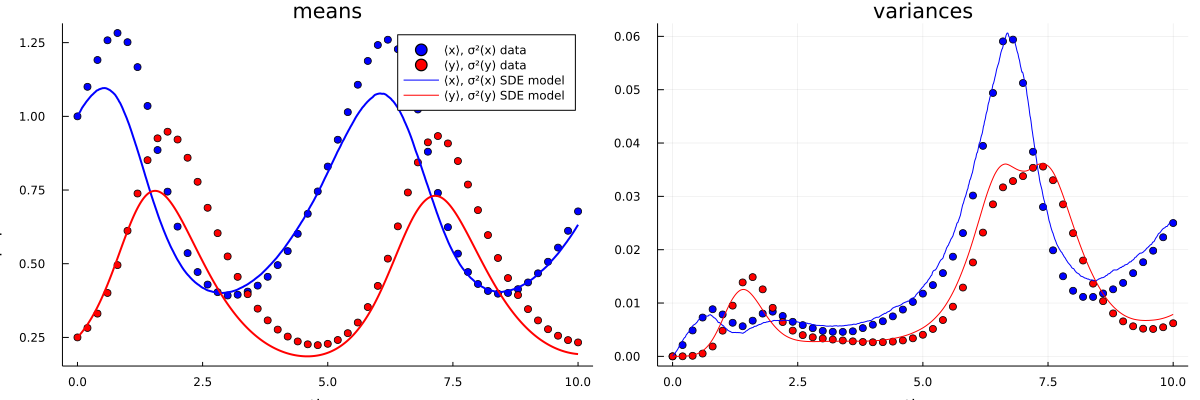

In [ ]:
t_detail = collect(0:0.01:Tf) 
opt_sol = solve(EnsembleProblem(SDEProblem(LV, u0, (0.0, Tf), opt_sampling.minimizer)), saveat = t_detail, trajectories = 1000)
opt_means, opt_vars = timeseries_steps_meanvar(opt_sol)

mean_comp = scatter(t_data, [m[1] for m in means], color = :blue,
                    xlabel = "time", ylabel = "population size", 
                    grid = false, title = "means", label = "⟨x⟩, σ²(x) data")
scatter!(mean_comp, t_data, [m[2] for m in means], color = :red, label = "⟨y⟩, σ²(y) data")
plot!(mean_comp, t_detail, [m[1] for m in opt_means], linewidth = 2, color = :blue, label = "⟨x⟩, σ²(x) SDE model")
plot!(mean_comp, t_detail, [m[2] for m in opt_means], linewidth = 2, color = :red, label = "⟨y⟩, σ²(y) SDE model")

var_comp = scatter(t_data, [v[1] for v in vars], color = :blue, legend = false, xlabel = "time", title = "variances")
scatter!(var_comp, t_data, [v[2] for v in vars], color = :red)
plot!(var_comp, t_detail, [v[1] for v in opt_vars], color = :blue)
plot!(var_comp, t_detail, [v[2] for v in opt_vars], color = :red)

plot(mean_comp, var_comp, size = (1200, 400))

Now we approach the same model identification problem via moment closure approximations in the hope of cutting down model evaluation cost, allowing us to identify better parameters in the same (or less) time. To that end, we construct an approximation of the moment dynamics of the process assuming that the distribution of the system state is approximately log-normal over the simulation horizon. Then, we can implement a simple loss function by comparing the moments predicted by the approximate model with those given by the data.

In [ ]:
LV_moments = moment_closure(generate_raw_moment_eqs(LV, 2), "log-normal")
u0map = deterministic_IC(u0, LV_moments)
closed_moment_prob = ODEProblem(LV_moments, u0map, (0.0, Tf), zeros(5))
function obj_MCA(p)
    prob = remake(closed_moment_prob; p=p)
    sol = solve(prob, Tsit5(), saveat = t_data)
    if sol.retcode == :Success
        obj = sum(norm(sol.u[i][1:2] - means[i])^2 for i in 1:length(t_data))
        obj += 1e4*sum((sol.u[i][3] - sol.u[i][1]^2  - vars[i][1])^2 for i in 1:length(t_data))
        obj += 1e4*sum((sol.u[i][5] - sol.u[i][2]^2  - vars[i][2])^2 for i in 1:length(t_data))
    else
        obj = 1e6
    end
    return obj
end

obj_MCA (generic function with 1 method)

As before, any suitable optimization routine can now be used to identify parameter values that result in a match between data and model prediction.

In [ ]:
pmap = Dict(i => findfirst(isequal(γ[i]), parameters(LV_moments.odes)) for i in 1:5)
p_init = Dict(γ[1] => 1.3, γ[2] => 1.5, γ[3] => 1.4, γ[4] => 2.2, γ[5] => 0.1)
p = [p_init[γ[pmap[i]]] for i in 1:5]
opt_MCA = Optim.optimize(obj_MCA, p, Optim.Options(time_limit = opt_sampling.time_run))

 * Status: success

 * Candidate solution
    Final objective value:     6.497421e-01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit 165)
    Iterations:    364
    f(x) calls:    756


And indeed, we identify model parameters that provide a better match between data and model, even if the original SDE model is being evaluated (note in particular that the below graphic confirms that the moment closure approximation provides a reasonably accurate approximation to the ensemble averages):

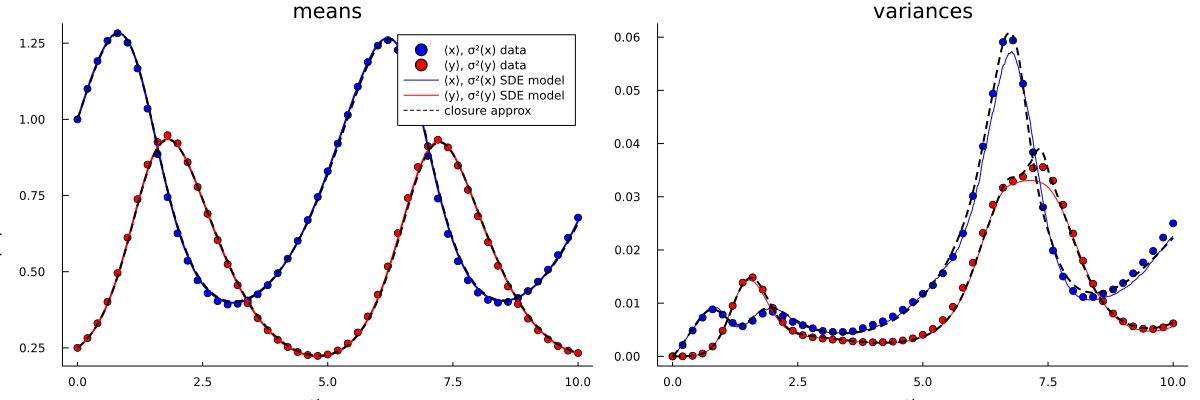

In [ ]:
p_opt = [γ[i] => opt_MCA.minimizer[pmap[i]] for i in 1:5]
t_detail = collect(0:0.01:Tf) 
opt_sol = solve(EnsembleProblem(SDEProblem(LV, u0, (0.0, Tf), p_opt)), saveat = t_detail, trajectories = 1000)
opt_means = [timestep_mean(opt_sol, i) for i in 1:length(t_detail)]
opt_vars = [timestep_meanvar(opt_sol, i)[2] for i in 1:length(t_detail)]

opt_sol_approx = solve(ODEProblem(LV_moments, u0map, (0.0, Tf), p_opt), saveat = t_detail)

mean_comp = scatter(t_data, [m[1] for m in means], color = :blue,
                     xlabel = "time", ylabel = "population size", 
                     grid = false, title = "means", label = "⟨x⟩, σ²(x) data")
scatter!(mean_comp, t_data, [m[2] for m in means], color = :red, label = "⟨y⟩, σ²(y) data")
plot!(mean_comp, t_detail, [m[1] for m in opt_means], linewidth = 2, color = :blue, label = "⟨x⟩, σ²(x) SDE model")
plot!(mean_comp, t_detail, [m[2] for m in opt_means], linewidth = 2, color = :red, label = "⟨y⟩, σ²(y) SDE model")
plot!(mean_comp, t_detail, [m[1] for m in opt_sol_approx.u], linewidth = 2, color = :black, linestyle = :dash, label = "closure approx")
plot!(mean_comp, t_detail, [m[2] for m in opt_sol_approx.u], linewidth = 2, color = :black, linestyle = :dash, label = nothing)


var_comp = scatter(t_data, [v[1] for v in vars], color = :blue, xlabel = "time", legend = false, title = "variances", grid = false)
scatter!(var_comp, t_data, [v[2] for v in vars], color = :red)
plot!(var_comp, t_detail, [v[1] for v in opt_vars], color = :blue)
plot!(var_comp, t_detail, [v[2] for v in opt_vars], color = :red)
plot!(var_comp, t_detail, [m[3] - m[1]^2 for m in opt_sol_approx.u], linewidth = 2, color = :black, linestyle = :dash)
plot!(var_comp, t_detail, [m[5] - m[2]^2 for m in opt_sol_approx.u], linewidth = 2, color = :black, linestyle = :dash)

plot(mean_comp, var_comp, size = (1200.0, 400.0))

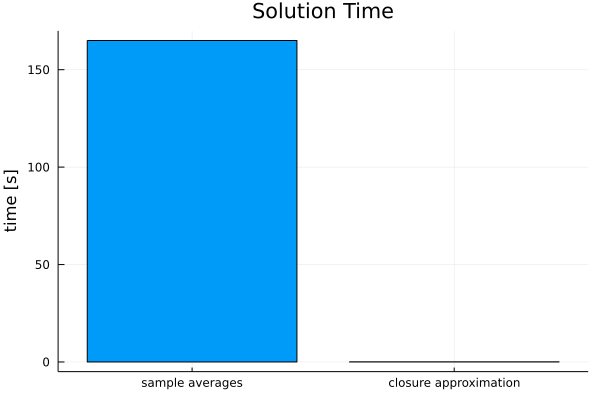

In [ ]:
bar(["sample averages", "closure approximation"], [opt_sampling.time_run, opt_MCA.time_run], title = "Solution Time", ylabel = "time [s]", legend = false )